In [93]:
import numpy as np

In [94]:
import pytesseract as pyt
# Set the path to the tesseract executable
pyt.pytesseract.tesseract_cmd = r'./Tesseract-OCR/tesseract.exe'  # Update this path if needed

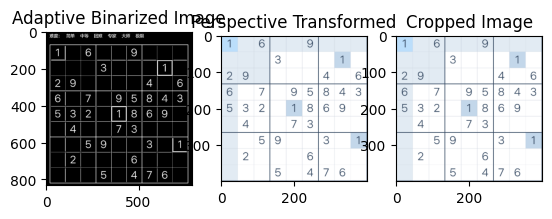

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adaptive_binarize(image):
    """自适应直方图二值化处理"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 转为灰度图
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return binary

def denoise_image(binary_image):
    """去噪处理"""
    # 使用开运算来去除小的噪点
    kernel = np.ones((3, 3), np.uint8)
    denoised = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    return denoised

def find_sudoku_outer_frame(image):
    """通过轮廓检测找到数独最外框"""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # 按轮廓面积排序
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)  # 近似轮廓
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:  # 找到四个角的矩形框
            return approx
    return None

def perspective_transform(image, pts):
    """根据四个角点进行透视变换"""
    width, height = 400, 400  # 透视变换后的宽高
    pts2 = np.float32([[0, 0], [0, width], [width, height], [height, 0]])  # 目标矩形框
    matrix = cv2.getPerspectiveTransform(np.float32(pts), pts2)
    transformed_image = cv2.warpPerspective(image, matrix, (width, height))
    return transformed_image

def crop_image(image):
    """裁剪去除图像中的无关部分"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

# 读取图像
image = cv2.imread('sudoku1.png')

# 步骤1：灰度化和自适应二值化
binary_image = adaptive_binarize(image)

# 步骤2：去噪处理
denoised_image = denoise_image(binary_image)

# 步骤3：查找数独的外框轮廓
sudoku_frame = find_sudoku_outer_frame(denoised_image)
if sudoku_frame is None:
    print("没有找到数独框架")
else:
    # 步骤4：透视变换
    transformed_image = perspective_transform(image, sudoku_frame)

    # 步骤5：裁剪多余部分
    cropped_image = crop_image(transformed_image)

    # 显示结果
    plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)), plt.title('Adaptive Binarized Image')
    plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)), plt.title('Perspective Transformed')
    plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)), plt.title('Cropped Image')
    plt.show()


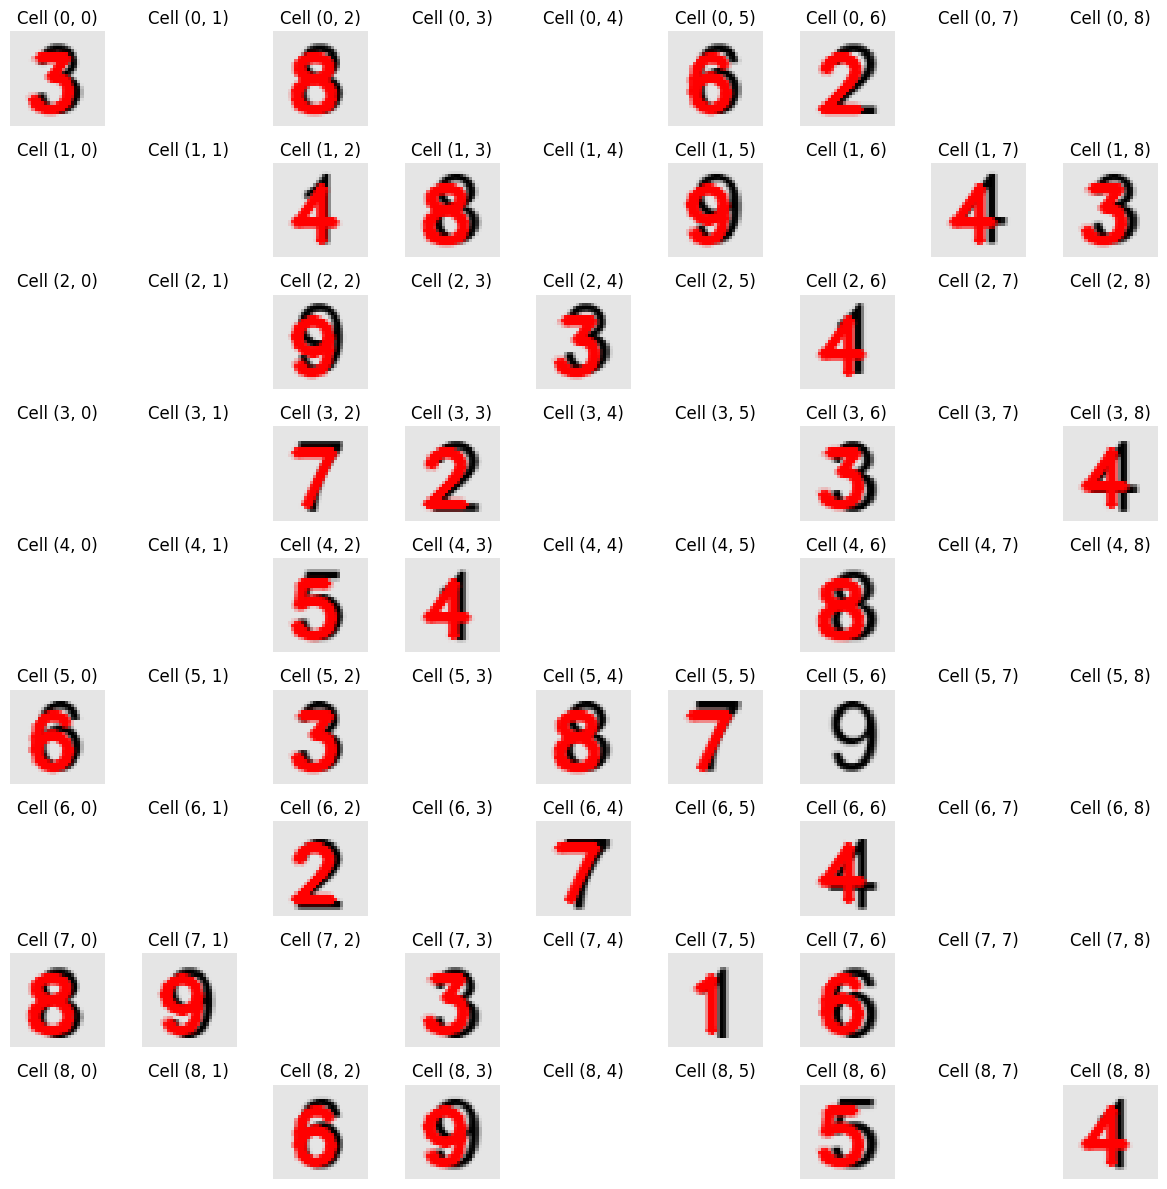

[['3', '.', '8', '.', '.', '6', '2', '.', '.'], ['.', '.', '4', '8', '.', '9', '.', '4', '3'], ['.', '.', '9', '.', '3', '.', '4', '.', '.'], ['.', '.', '7', '2', '.', '.', '3', '.', '4'], ['.', '.', '5', '4', '.', '.', '8', '.', '.'], ['6', '.', '3', '.', '8', '7', '.', '.', '.'], ['.', '.', '2', '.', '7', '.', '4', '.', '.'], ['8', '9', '.', '3', '.', '1', '6', '.', '.'], ['.', '.', '6', '9', '.', '.', '5', '.', '4']]


In [96]:
import pytesseract as pyt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 设置 Tesseract 可执行文件路径
pyt.pytesseract.tesseract_cmd = r'C:/Application/Tesseract-OCR/tesseract.exe'  # 如果需要，请更新路径

def crop_cell(cell_image, crop_ratio=0.2):
    """裁剪格子边缘，只保留数字区域"""
    height, width = cell_image.shape[:2]
    
    # 计算裁剪的边界
    crop_top = int(height * crop_ratio)
    crop_bottom = int(height * (1 - crop_ratio))
    crop_left = int(width * crop_ratio)
    crop_right = int(width * (1 - crop_ratio))
    
    # 裁剪出数字部分
    cropped_cell = cell_image[crop_top:crop_bottom, crop_left:crop_right]
    return cropped_cell

def enhance_image_for_ocr(cell_image):
    """增强图像，准备 OCR 识别"""
    # 转为灰度图像
    gray = cv2.cvtColor(cell_image, cv2.COLOR_BGR2GRAY)
    
    # 使用自适应阈值进行二值化
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    
    # 去噪声：使用中值滤波
    denoised = cv2.medianBlur(binary, 3)
    
    return denoised

def recognize_number_from_image(cell_image):
    """使用 Tesseract 识别单个小格子中的数字"""
    # 增强图像
    enhanced_image = enhance_image_for_ocr(cell_image)
    
    # 使用 Tesseract 进行 OCR 识别
    text = pyt.image_to_string(enhanced_image, config='--psm 6 --oem 3')  # psm 6 适用于单个文本区域的识别
    return text.strip()

def recognize_number_with_voting(cell_image, num_recognitions=5, early_exit=True):
    """识别一个格子中的数字，通过投票机制确定最终结果"""
    recognitions = []
    
    for i in range(num_recognitions):
        digit = recognize_number_from_image(cell_image)
        recognitions.append(digit)
        
        # 如果前两次识别一致，则退出
        if early_exit and i == 1 and recognitions[0] == recognitions[1]:
            break
    
    # 统计出现次数最多的识别结果
    counter = Counter(recognitions)
    most_common = counter.most_common(1)[0][0]
    
    return most_common

def split_image_into_grid(image, grid_size=(9, 9), vertical_offset=0, horizontal_offset=0):
    """切分图像为小格子，并根据偏移量进行调整"""
    height, width = image.shape[:2]
    cell_height = height // grid_size[0]
    cell_width = width // grid_size[1]
    
    grid_cells = []
    
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # 计算每个格子的坐标，并加上偏移量
            x1 = j * cell_width + horizontal_offset
            y1 = i * cell_height + vertical_offset
            x2 = (j + 1) * cell_width + horizontal_offset
            y2 = (i + 1) * cell_height + vertical_offset
            # 确保不超出图像范围
            x1 = max(x1, 0)
            y1 = max(y1, 0)
            x2 = min(x2, width)
            y2 = min(y2, height)
            cell = image[y1:y2, x1:x2]
            grid_cells.append((i, j, cell))  # 存储每个格子的图像和其坐标
    return grid_cells

def display_grid_cells_with_numbers(grid_cells, grid_size=(9, 9), crop_ratio=0.2, num_recognitions=5):
    """在每个小格子上标记识别出来的数字，并返回识别的数独矩阵"""
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
    axes = axes.flatten()  # Flatten to easily index the 2D grid
    
    # 创建一个 9x9 的零矩阵来存储识别的数字，使用 '.' 表示空单元
    sudoku_grid = [['.' for _ in range(grid_size[1])] for _ in range(grid_size[0])]
    
    for idx, (i, j, cell) in enumerate(grid_cells):
        ax = axes[idx]
        
        # 裁剪格子，只保留数字部分
        cropped_cell = crop_cell(cell, crop_ratio)
        
        # 使用投票机制识别数字
        digit = recognize_number_with_voting(cropped_cell, num_recognitions)
        
        # 如果识别到数字，则填充到数独网格中
        if digit.isdigit():
            sudoku_grid[i][j] = digit
            cell_with_text = cropped_cell.copy()
            cv2.putText(cell_with_text, digit, (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
        else:
            cell_with_text = cropped_cell
        
        # 显示带数字的格子
        ax.imshow(cv2.cvtColor(cell_with_text, cv2.COLOR_BGR2RGB))  # 将 BGR 转换为 RGB 以正确显示
        ax.set_title(f"Cell ({i}, {j})")
        ax.axis('off')  # 去掉坐标轴
    
    plt.tight_layout()
    plt.show()
    
    # 返回识别后的数独网格
    return sudoku_grid

# 假设你已经有了裁剪过的图像 cropped_image
# 例如，可以通过以下代码读取图像： 
# image = cv2.imread('path_to_sudoku_image.jpg')

# 设置偏移量
vertical_offset, horizontal_offset = 3, 3  # 垂直，水平方向的偏移量

# 切分图像为 9x9 小格子，并应用偏移
grid_cells = split_image_into_grid(cropped_image, vertical_offset=vertical_offset, horizontal_offset=horizontal_offset)

# 显示这些带有识别数字的格子，并返回识别后的数独矩阵
sudoku_grid = display_grid_cells_with_numbers(grid_cells, crop_ratio=0.15, num_recognitions=5)

# 输出识别的数独矩阵
print(sudoku_grid)


In [97]:
board = [['3', '.', '8', '.', '.', '6', '2', '.', '.'], 
         ['.', '.', '1', '8', '.', '9', '.', '4', '3'], 
         ['.', '.', '9', '.', '3', '.', '1', '.', '.'], 
         ['.', '.', '7', '2', '.', '.', '3', '.', '4'], 
         ['.', '.', '5', '1', '.', '.', '8', '.', '.'], 
         ['6', '.', '3', '.', '8', '7', '9', '.', '.'], 
         ['.', '.', '2', '.', '7', '.', '4', '.', '.'], 
         ['8', '9', '.', '3', '.', '1', '6', '.', '.'], 
         ['.', '.', '6', '9', '.', '.', '5', '.', '1']]

# 输出结果
print(board)

[['3', '.', '8', '.', '.', '6', '2', '.', '.'], ['.', '.', '1', '8', '.', '9', '.', '4', '3'], ['.', '.', '9', '.', '3', '.', '1', '.', '.'], ['.', '.', '7', '2', '.', '.', '3', '.', '4'], ['.', '.', '5', '1', '.', '.', '8', '.', '.'], ['6', '.', '3', '.', '8', '7', '9', '.', '.'], ['.', '.', '2', '.', '7', '.', '4', '.', '.'], ['8', '9', '.', '3', '.', '1', '6', '.', '.'], ['.', '.', '6', '9', '.', '.', '5', '.', '1']]


In [98]:
def is_valid(board, row, col, num):
    # 检查行中是否有重复
    for x in range(9):
        if board[row][x] == num:
            return False

    # 检查列中是否有重复
    for x in range(9):
        if board[x][col] == num:
            return False

    # 检查3x3方格内是否有重复
    start_row = row - row % 3
    start_col = col - col % 3
    for i in range(3):
        for j in range(3):
            if board[i + start_row][j + start_col] == num:
                return False
    return True

def solve_sudoku(board):
    empty_cell = find_empty_location(board)
    if not empty_cell:
        return True  # 找不到空位，说明数独已解完
    row, col = empty_cell

    for num in map(str, range(1, 10)):
        if is_valid(board, row, col, num):
            board[row][col] = num
            if solve_sudoku(board):
                return True
            board[row][col] = '.'  # 回溯
    return False

def find_empty_location(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == '.':
                return (i, j)
    return None

# 提供的数独板面
sudoku_board = board

# 尝试解决数独
if solve_sudoku(sudoku_board):
    print("数独有解")
else:
    print("数独无解")

数独有解


In [100]:
from typing import List

class Solution:
    def solveSudoku(self, board: List[List[int]]) -> None:
        """
        Do not return anything, modify board in-place instead.
        """
        if self.backtracking(board):
            print("Solution found.")
        else:
            print("No solution exists.")

    def backtracking(self, board: List[List[int]]) -> bool:
        for i in range(len(board)):  # 遍历行
            for j in range(len(board[0])):  # 遍历列
                if board[i][j] != 0:
                    continue
                for k in range(1, 10):
                    if self.is_valid(i, j, k, board):
                        board[i][j] = k
                        if self.backtracking(board):  # 继续回溯
                            return True
                        board[i][j] = 0  # 恢复为0，尝试下一个数字
                # 若数字1-9都不能成功填入空格，返回False无解
                return False
        return True  # 找到解，返回True

    def is_valid(self, row: int, col: int, val: int, board: List[List[int]]) -> bool:
        # 判断同一行是否冲突
        for i in range(9):
            if board[row][i] == val:
                return False
        # 判断同一列是否冲突
        for j in range(9):
            if board[j][col] == val:
                return False
        # 判断同一九宫格是否有冲突
        start_row = (row // 3) * 3
        start_col = (col // 3) * 3
        for i in range(start_row, start_row + 3):
            for j in range(start_col, start_col + 3):
                if board[i][j] == val:
                    return False
        return True

board = sudoku_board
# 解数独
solution = Solution()
solution.solveSudoku(board)

# 输出解后的数独
print("解:")
for row in board:
    print(row)

Solution found.
解:
['3', '4', '8', '7', '1', '6', '2', '9', '5']
['5', '6', '1', '8', '2', '9', '7', '4', '3']
['2', '7', '9', '5', '3', '4', '1', '6', '8']
['9', '8', '7', '2', '6', '5', '3', '1', '4']
['4', '2', '5', '1', '9', '3', '8', '7', '6']
['6', '1', '3', '4', '8', '7', '9', '5', '2']
['1', '5', '2', '6', '7', '8', '4', '3', '9']
['8', '9', '4', '3', '5', '1', '6', '2', '7']
['7', '3', '6', '9', '4', '2', '5', '8', '1']
